# Sequential Gausssian Simulation

### Reasoning for building a SGSIM model:
- We want to have a complete spatial model that honors the global distribution and variogram of our data.

Kriging gives the most likely value at each location in a spatial model, and at distances greater than the range, simple kriging assusmes those locations are the global mean of the data. This effect often misses the 
short-range variability and heterogeneity in geospatial data.
- SGSIM corrects for Kriging's low model variance by working in gaussian space, where high values and low values tend not to bunch up. (honors global distribution / histogram)
- SGSIM corrects for Kriging's continuous variogram or 'smoothness' (honors spatial variablity)

In [1]:
import os                                                  
import numpy as np                                        
import pandas as pd                                       
import matplotlib.pyplot as plt    

import pprint
import math
import scipy
import random
from numpy.random import randn
from scipy.stats import norm
from IPython.display import Image
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
import itertools as it                               #flattens lists for widgets
from scipy.interpolate import griddata



In [2]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

Set working directory

In [3]:
# os.chdir("C:\Users\admin1\Desktop\resources\CSE Project")                                  

Lets start by creating a Gaussian distrubted porosity dataset.

In [4]:
porosity  = np.array([])
normal = pd.read_csv('norm.csv')
por = np.array(normal['p'])
count = np.array(normal['count'])
c=0
for i in range(0,len(por)):
    c=0
    while c <= count[i]:
        c += 1
        porosity = np.append(porosity,por[i])
por_samples = np.array([])
for i in range(100):
    index = np.random.randint(0,len(porosity))
    por_samples = np.append(por_samples,porosity[index])

df_iso = pd.DataFrame(por_samples,columns = ['porosity'])
# porosity.describe()
df_iso.describe()

,porosity
count,100.000000
mean,0.155555
std,0.028080
min,0.098416
25%,0.134855
50%,0.156571
75%,0.178287
max,0.210309


(array([ 4., 12.,  8., 10., 14., 15., 11.,  7., 17.,  2.]),
 array([0.098416  , 0.10960528, 0.12079456, 0.13198384, 0.14317312,
        0.1543624 , 0.16555168, 0.17674096, 0.18793024, 0.19911952,
        0.21030879]),
 <BarContainer object of 10 artists>)

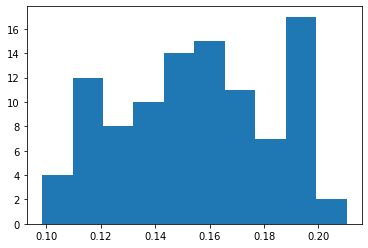

In [5]:
plt.hist(df_iso)

To make this Spatial data, lets assign X and Y locations for each porosity location equally spaced across 10,000m. Here, every well locaiton is 1000 meters apart.

Let's visualize the data.

C:\Users\admin1\anaconda3\lib\site-packages\geostatspy\GSLIB.py:323: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(


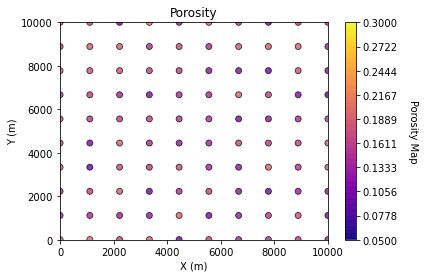

In [6]:
x = np.tile(np.linspace(0,10000,10), 10)
y = np.repeat(np.linspace(10,10000,10), 10)
df_iso['X'] = x
df_iso['Y'] = y

GSLIB.locmap_st(df_iso,'X','Y','porosity',0,10000,0,10000,.05,.3,'Porosity','X (m)','Y (m)','Porosity Map',plt.cm.plasma)

## Variogram

For now lets work with our isotropic, Gaussian distrubted porosity data. This means we can use an isotropic variogram in our SGSIM model: 
- hmin = hmax

Lets determine what these values are by constructing a variogram

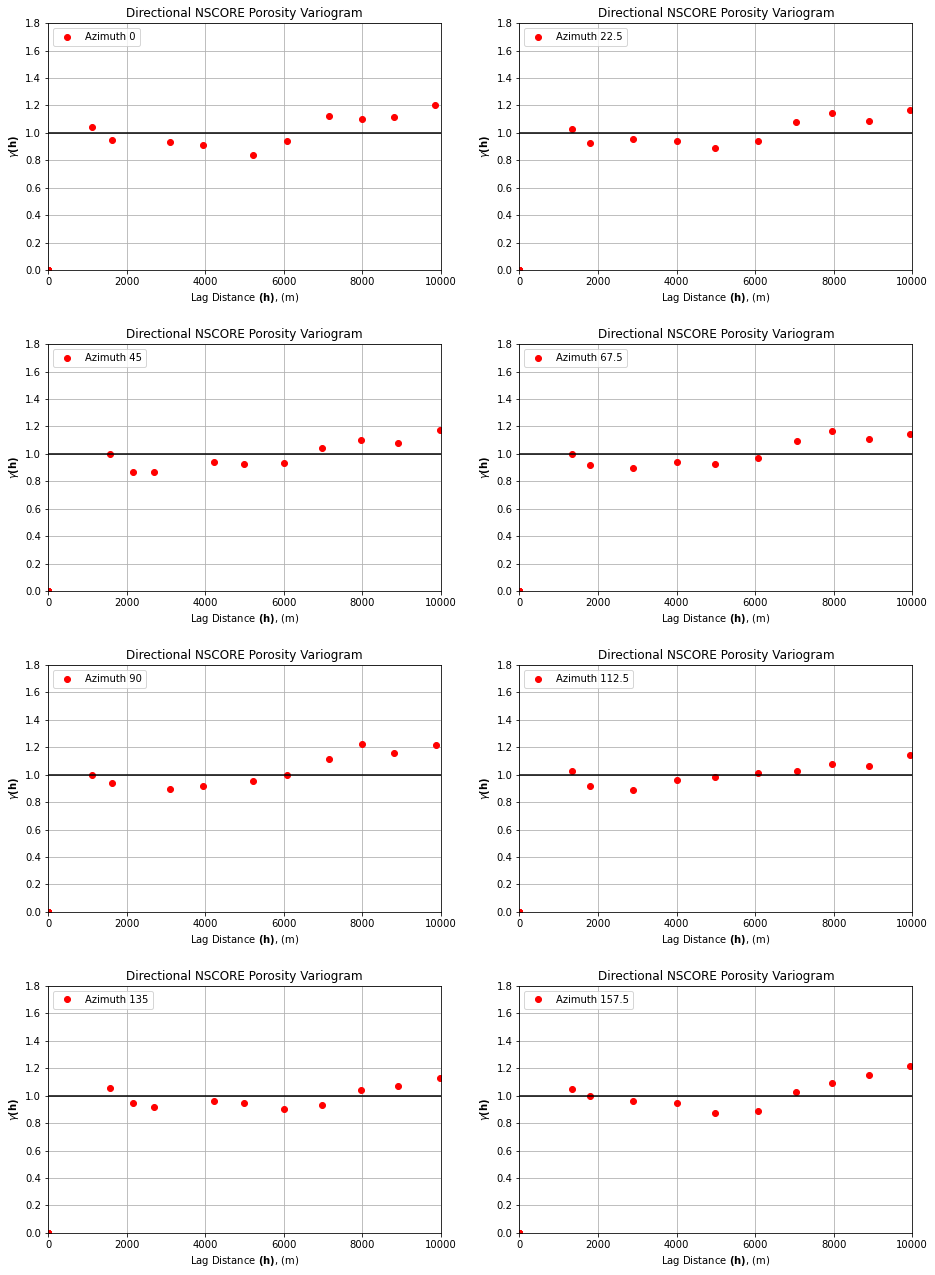

In [7]:
tmin = -9999.; tmax = 9999.                             # no trimming of our data 
lag_dist = 1000.0; lag_tol = 1000.0; nlag = 20;     # maximum lag is 1000m, log_tol > 1/2 lag distance (smoothing)
bandh = 9999.9; atol = 25                             # give bandwidth no effect: directional variograms
isill = 1                                               # standardize sill(equal to variance = 1 in normal trans)
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to consider

#Store results in these arrays
lag = np.zeros((len(azi_mat),nlag+2))
variogram = np.zeros((len(azi_mat),nlag+2))
z = np.zeros((len(azi_mat),nlag+2))

for azi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[azi,:], variogram[azi,:], z[azi,:] = geostats.gamv(df_iso,"X","Y","porosity",tmin,tmax,
                                                                lag_dist,lag_tol,nlag,azi_mat[azi],
                                                                atol,bandh,isill)
#visualize each variogram 
    plt.subplot(4,2,azi+1)
    plt.plot(lag[azi,:],variogram[azi,:],'o',color = 'r',label = 'Azimuth ' +str(azi_mat[azi]))
    plt.plot([0,10000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Porosity Variogram')
    plt.xlim([0,10000])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

We see that in most directions, our data set has the same range of 1000m, which is expected in a uniformly spaced data set that was spaced the same distance. We should only retain information about a point that is 1000m away which makes sense if that is the only distance at which points exist. 

We know have our variogram model parameters to input to our SGSIM model.


## SGSIM Model
Lets build a SGSIM model using simple kriging estimator, to do this we will implement the SGSIM fuction from
geostatspy library and set the fuction parameter 'ktype' = 0

- By using simple kriging we are not constraining the weights assigned to data to model (as done in ordinary kriging where the sum of weights = 1 and the global mean of data does not need to be known, local mean is used instead), and we are working with the residual from the mean. Doing so assumes stationarity in our data i.e. no trends in the data.


 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
                 Weighted Average              = 0.1556
                 Weighted Variance             = 0.0008
                 Weighted Transformed Average  = 0.0252
                 Weighted Transformed Variance = 0.9895
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0224 (close to 0.0?)
                                   variance = 0.8509 (close to gammabar(V,V)? approx. 1.0)


C:\Users\admin1\anaconda3\lib\site-packages\geostatspy\GSLIB.py:700: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  plt.scatter(


simsk  100


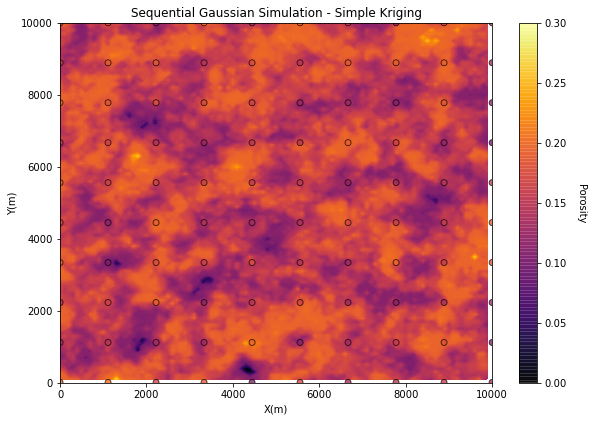

In [8]:
# we are setting our working variables that will be inputs to our sgsim fuction
nx = 100; ny = 100; xsiz = 100.0; ysiz = 100.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 400; skmean = 0

#instatiation of a variogram model with necessary function parameters nugget effect, major & minor ranges, 
#azimuth, etc. 
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=1000,hmin1=1000)

#trimming limits (no effect on data)
tmin = 0; tmax = 10000

#SGSIM model
sim_sk = geostats.sgsim(df_iso,'X','Y','porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

#visualize created SGSIM model
xmin = 0.0; xmax = 10000.0; ymin = 0.0; ymax = 10000.0; cmap = plt.cm.inferno
plt.subplot(111)  
GSLIB.locpix_st(sim_sk,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df_iso,'X','Y','porosity',
                'Sequential Gaussian Simulation - Simple Kriging','X(m)','Y(m)','Porosity',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.25, top=1.25, wspace=0.2, hspace=0.2)
print('simsk ', len(sim_sk))

# Imposed Strategy and Bootsrap

Now that we have a full model of heterogeneity, We are going to compare the outcomes between two methods of Bootstrap.

#### Method 1:  Journelian Bootstrap:

Bootstrap is a means to build an uncertainty distribution for any statsitic by leveraging the scarcity of data. It performs mulitple monte carlo simulations based on the number of available data to build an uncertainty model.

- Using our full SGSIM, randomly drill n wells using montecarlo simulation in our area of interest. From these wells, take the porosity of each well and store the porosity in a total distribution that will be used for bootstrap.
- Repeat this drilling strategy by generating more realizations (SGSIM #2,#3,#n), but keep the well locations the same across all SGSIM models and record the porosity for all wells in every SGSIM realization. For example you want to drill 50 wells, and will make 5 SGSIM models. Your total distibution will have 250 samples of porosity.
- Once you have your total distribution of porosity, perform bootstrap on the data by randomly sampling with replacement 250 times. This is 1 realization. Take the mean of each realization as a single value and store it in the global distribution of mean porosity. Repeat for as many times as you need to build a good measure of uncertainty/good distribution of mean porosity. 

#### Method 2: Journelian Bootstrap with Imposed Strategy:

This method will add a stategy to the spatial bootsrap process in method 1. The strategy will implement a predetermined decision criteria that dictates the sampling process in bootsrap.

##### Strategy:

- Drill a well in the same random location of the porosity map as in method 1(for comparison), this is well #1. 
#### If this well is a 'good well' or it exceeds a porosity value determined to be sufficiently high:
-  Drill another well (well #2) located in the 'annulus' of well #1. Where the annulus is the region surrounding the well defined as the difference between determined radii R1, R2 (R1 > R2). Our intention with a 'good well' outcome is to drill a well close to well #1 (within R1), but not too close (inside R2). 
#### If this well is a 'bad well' or its porosity value is lower than a value determined to be sufficiently low:
- Drill well #2 outside of R1 of well #1. Our intention with a 'bad well' outcome is to drill a well far enough away from a bad well to increase the likelihood of drilling a better well with the next drill.

### Assumptions:
With a basic drilling strategy in place, lets discuss some key assumptions that we will make:

#### How close is close? - Determining R1 & R2
- In spatial context, We want to honor the variogram of our generated SGSIM model. We do this by assuming R1, the radius of distance that defines the area of 'close' new drills, is equal to the major axis range of the variogram used to generate the SGSIM model. The range of a variogram is the maximum distance away from a known data location where we can expect to still have information from the known data location to make a prediction. Predicting outside of this range would be naive prediction with regards to the information from the known data location. This is why when we have a good well we drill within the range/R1 to keep the information from the good well, and when we drill a bad well, we drill outside the range/R1 to miminimze the influence of the bad well on our next drill. 

- We never want to drill too close to our previous drill becuase its likely that we could get stuck drilling the same area becasue the subsequent well will always be good. This also doesnt make practical sense in real-world applications where operaters tend to maximize the productive field by drilling at strategically spaced locations. We can determine the minimum distance to avoid drilling a subsequent well as the minor axis range of the variogram model of our raw data. No matter which azimuth you drill a new well along within R2, your data will still share information from your previous well, so we will drill outside of this radius always. 



### Method 1:  Journelian Bootstrap

Before we build multiple SGSIM models and perform bootstrap, lets demonstate the process for a single SGSIM model.

- We want to sample from our exhaustive SGSIM model to gather the distrubution of 'wells' that will each have a porosity value. To do this, we can flatten our model and randomly sample from the 1D-array with as many 'wells' as we want to drill (say 50). 
- Now to build the uncertainty model, we perform bootsrap on the 50 samples, randomly sampling 50 times with replacement to build a single realization. We repeat this enough times to build an uncertainty model of mean porosity across our 50 wells.




Text(0.5, 1.0, 'Uncertainty in Mean Porosity of well locations')

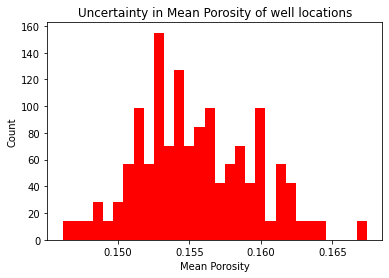

In [9]:
sample_array = sim_sk.flatten()

wells = np.array([])                               #an array of random samples of our SGSIM model

for i in range(0,50):                              #want to drill 50 wells
    index = np.random.randint(0,len(sample_array)) #want to pull from entire 10,000 data points of SGSIM model
    wells = np.append(wells,sample_array[index])

mean_por = np.array([])
n = 0
while n < 100:                                     #n realizations (number of times we drill 50 wells)
    n+=1
    samples = np.array([])
    for i in range(0,len(wells)):
        index = np.random.randint(0,len(wells))
        samples = np.append(samples,wells[index])  #builds 1 full realization of 50 wells
    mean = np.mean(samples)
    mean_por = np.append(mean_por,mean)

#Visualize uncertainty distribution in single SGSIM model:

bins = 30
plt.subplot(1,1,1)
n, bins,patches = plt.hist(mean_por,bins,facecolor = 'r',density=True)
plt.xlabel('Mean Porosity' )
plt.ylabel('Count')
plt.title('Uncertainty in Mean Porosity of well locations')
    
    


## Journelian Bootstrap
Now that we understand bootstrap in a single SGSIM model, lets follow the Journelian approach where we build multiple SGSIM models that all contribute to the total porosity distribution that we will perform bootstrap on. We need to change the random number seed for the SGSIM model to ensure we get a new model every time we perform a bootstrap realization.

Its important that we keep the drill locations the same accross our SGSIM models for this approach. 


 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
                 Weighted Average              = 0.1556
                 Weighted Variance             = 0.0008
                 Weighted Transformed Average  = 0.0252
                 Weighted Transformed Variance = 0.9895
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0126 (close to 0.0?)
                                   variance = 0.766 (close to gammabar(V,V)? approx. 1.0)
sampy:  0.20455943824685752
len 10000
drill_loc  [9506. 5239. 7048. 4480. 6289. 7484. 6684.  819. 2564. 1380

Text(0.5, 1.0, 'Journelian Bootstrap')

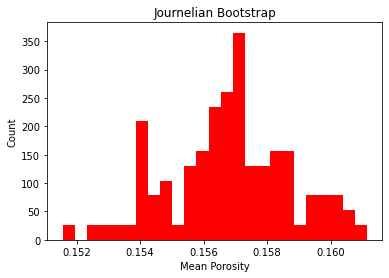

In [48]:
SGSIMreals = 0   #of SGSIM Models for a distribution
ndata = 50
sample_array = sim_sk.flatten()

#take the SGSIM code(minus visualization) from above and work it into a loop for automation.

wells = np.array([]) 
drill_loc = np.array([])
seeds = 0
for i in range(0,50):                                   #drill 50 wells in the same location so we store this in 'drill_loc'
    index = int(np.random.randint(0,len(sample_array))) #pull from entire 10,000 data points of SGSIM model
    drill_loc = np.append(drill_loc,index)

while SGSIMreals < 5:           #number of isotropic SGSIM models for global distribution
    SGSIMreals += 1
    
    nx = 100; ny = 100; xsiz = 100.0; ysiz = 100.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
    ndmin = 0; ndmax = 10; radius = 400; skmean = 0
    vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45.0,hmaj1=1000,hmin1=1000)
    tmin = -999; tmax = 999

#SGSIM model
    seeds += 1
    sim_sk = geostats.sgsim(df_iso,'X','Y','porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
                twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
                nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seeds,
                ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
                mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

    
    sample_array = sim_sk.flatten()
    sampy = sample_array[50]
    print('sampy: ', sampy)
    print('len', len(sample_array))
    print('drill_loc ',drill_loc)

    

    for i in range(0,len(drill_loc)):
        index1 = int(drill_loc[i])
        wells = np.append(wells,sample_array[index1])
    print('# wells ',len(wells))        

        
# by now we have our global distribution of wells drilled in multiple SGSIM models at the same locations 
# now perform bootstrap

mean_por = np.array([])
n = 0
while n < 100:                                     #n realizations (number of times sample 250 wells)
    n+=1
    samples = np.array([])
    for i in range(0,len(wells)):
        index = np.random.randint(0,len(wells))
        samples = np.append(samples,wells[index])  #builds 1 full realization of all wells
    mean = np.mean(samples)
    mean_por = np.append(mean_por,mean)
    
print('bins ',len(mean_por))
#Visualize
    
bins = 25
plt.subplot(1,1,1)
n, bins,patches = plt.hist(mean_por,bins,facecolor = 'r',density=True)
plt.xlabel('Mean Porosity')
plt.ylabel('Count')
plt.title('Journelian Bootstrap')


Lets get some summary statistics on our realizations.

In [27]:
JournelRealsDF = pd.DataFrame(mean_por, columns = ['Journelian Mean Porosity'])
JournelRealsDF.describe()


,Journelian Mean Porosity
count,100.000000
mean,0.157765
std,0.002050
min,0.151727
25%,0.156381
50%,0.157800
75%,0.159039
max,0.164146


This distribution can serve as our basis for comparing a similar method but with a imposed drilling strategy

### Method 2: Journellian Bootstrap with Imposed Strategy


To apply our drilling strategy to our isotropic SGSIM models, we simply impelment our decision criteria into the sampling process from before.

Lets first decide on 'sufficiently high' and 'sufficiently low' porosity values by looking at our original summary statistics.

In [28]:
df_iso.describe()

,porosity,X,Y
count,100.000000,100.000000,100.000000
mean,0.155555,5000.000000,5005.000000
std,0.028080,3207.501495,3204.293994
min,0.098416,0.000000,10.000000
25%,0.134855,2222.222222,2230.000000
50%,0.156571,5000.000000,5005.000000
75%,0.178287,7777.777778,7780.000000
max,0.210309,10000.000000,10000.000000


In [50]:
threshold_por = np.percentile(df_iso['porosity'],75)
print(threshold_por)

0.1782868445


We choose any porosity sampled below the P75 to be sufficiently low and a 'bad well' and any porosity sampled above the P75 to be sufficiently high and a 'good well'.

### Implement Strategy

Now lets implement our strategy into our sampling process using loops. Before we implement this into our journellian method, lets demonstrate the process on a single SGSIM model.

Our strategy loop will be worked into the sampling loop before we perform bootstrap so that we have our 'filtered' porosity distribution. 

We first need to develope a method to selectively sample from our defined annular region. 

### Build Annular Region
Recall the Equation of a circle.

source: https://youtu.be/JvDpYlyKkNU


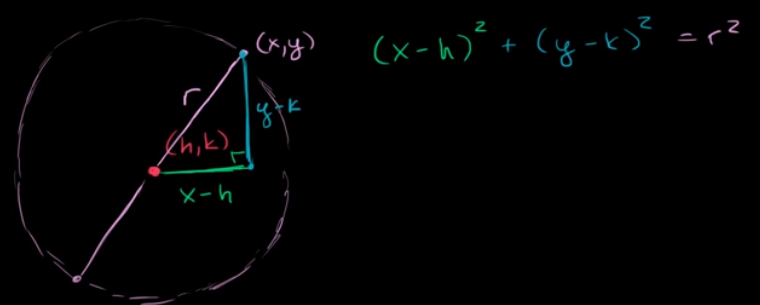

In [30]:
print('source: https://youtu.be/JvDpYlyKkNU')
Image("Equation of a Circle.PNG")



The output of our SGSIM model is an array of porosity values overlayed on X-Y coordinate arrays that we can use to define our annular regions with circles.

Once the anular region is defined, we can take the corresponding porosity values for those selected X-Y coordinates as the boundaries of the circles.


In [31]:
df_iso

,porosity,X,Y
0,0.197058,0.000000,10.0
1,0.202947,1111.111111,10.0
2,0.170557,2222.222222,10.0
3,0.191169,3333.333333,10.0
4,0.107250,4444.444444,10.0
...,...,...,...
95,0.195586,5555.555556,10000.0
96,0.157307,6666.666667,10000.0
97,0.114611,7777.777778,10000.0
98,0.167613,8888.888889,10000.0


## Interactive Imposed Strategy Sampling

This block allows the user to scroll thorugh sampling iterations and see the strategy-imposed decisions in effect.
- Keep in mind that the annular region defined for this example is not meaningful for an isotraopic variogram where R1 = R2 and the 'annular' region would be any point inside R1 = R2, which is a circular region. 
The main focus is so showcase the sampling procedure, so an arbitray R2 (hmin variogram range) is chosen as a fraction of R1.

0.1782868445
wellpor:  0.192641512
0.1782868445
wellpor:  0.19748052300811342
0.1782868445
wellpor:  0.1861241286834038
0.1782868445
wellpor:  0.19558820511619943
0.1782868445
wellpor:  0.19116923800000002
0.1782868445
wellpor:  0.18822469100000003
0.1782868445
wellpor:  0.18304324700162738
0.1782868445
wellpor:  0.194113786
0.1782868445
wellpor:  0.197058333


Output()

# of good wells  9
[0.19264151 0.19748052 0.18612413 0.19558821 0.19116924 0.18822469
 0.18304325 0.19411379 0.19705833]


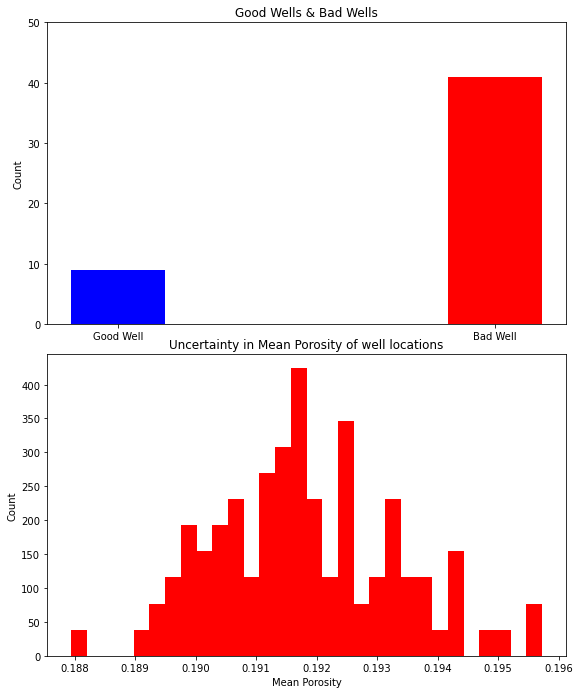

In [58]:
wellcount = 50
iteration = widgets.FloatSlider(min=1.0, max = 50.0, value = 0.01, step = 1.0, 
                            description = 'iteration',orientation='horizontal',
                            layout=Layout(width='500px', height='10px'))
iteration.style.handle_color = 'gray'
l = widgets.Text(value='                                     Interactive Strategy Visualization',
                 layout=Layout(width='500px', height='50px'))
ui1 = widgets.HBox([iteration],) # basic widget formatting    
ui = widgets.VBox([l,ui1],)

sample_array = sim_sk.flatten()
nx = 100; ny = 100; xsiz = 100.0; ysiz = 100.0
xmin = 0.0; xmax = 10000.0; ymin = 0.0; ymax = 10000.0

x = np.linspace(xmin,xmax,nx)
y = np.linspace(ymax,ymin,ny)
X,Y = np.meshgrid(x,y)
px = X.flatten()
py = Y.flatten()

goodwells = np.array([])                            #arrays of filterd samples from our SGSIM model using srategy
badwells = np.array([])
index = np.random.randint(0,len(sample_array))     #want to start with a random location from SGSIM model

wellx = np.array([])                              #arrays to store cordinates for the widget plot
welly = np.array([])
R1x = []
R1y = []
R2x = []
R2y = []

well_x = px[index]                                 #initial well location
well_y = py[index]
well_por = sample_array[index]


for i in range(0,wellcount):                              #want to drill 50 wells

    #define R1, R2 from major and minor axes, (here welll assume R2 is a fraction of R1 for demonstration
    #since they are equal when Isotropic)
    Hmaj = 1000
    Hmin = Hmaj/3
    R1 = np.array([])
    for i in range(len(px)):
        R1 = np.append(R1,np.sqrt((px[i]-well_x)**2 + (py[i]-well_y)**2))

    annulus = np.where((R1 <= Hmaj)&(R1 > Hmin))[0]        #regions of good and bad wells
    outsideR1 = np.where(R1 > Hmaj)[0]
    
    r1 = np.where(((R1 > Hmaj-50))&(R1<(Hmaj+50)))[0]        #Radii for plotting
    r2 = np.where(((R1 > Hmin-50))&(R1<(Hmin+50)))[0]
    
    annulusx = np.array([])                                #good well arrays
    annulusy = np.array([])
    annuluspor = np.array([])
        
    out_annulusx = np.array([])                            #bad well arrays
    out_annulusy = np.array([])
    out_annuluspor = np.array([])                              

    r1x = []                                               #lists for interactive plot; store radii cordinates 
    r1y = []
    r2x = []
    r2y = []

    for i in r1:
        r1x.append(px[i])
        r1y.append(py[i])
    for i in r2:
        r2x.append(px[i])
        r2y.append(py[i])

    for i in annulus:                                     #gathers x,y locations & porosities inside and outside annulus
        annulusx = np.append(annulusx,px[i])
        annulusy = np.append(annulusy,py[i])
        annuluspor = np.append(annuluspor,sample_array[i])
    for i in outsideR1:
        out_annulusx = np.append(out_annulusx,px[i])
        out_annulusy = np.append(out_annulusy,py[i])
        out_annuluspor = np.append(out_annuluspor,sample_array[i])

    if well_por >= threshold_por:                      #if a good well, sample stored for bootstrap, look inside annulus
        
        print(threshold_por)
        print('wellpor: ', well_por)
        goodwells = np.append(goodwells,well_por)

        index = np.random.randint(0,len(annuluspor))
        well_x = annulusx[index]
        well_y = annulusy[index]
        well_por = annuluspor[index]
        
    elif well_por < threshold_por:                 #if a bad well, sample not stored for bootstrap , look outside annulus
        
        
        badwells = np.append(badwells,well_por)
        
        index = np.random.randint(0,len(out_annuluspor))
        well_x = out_annulusx[index]
        well_y = out_annulusy[index]
        well_por = out_annuluspor[index]
        

    wellx = np.append(wellx,well_x)
    welly = np.append(welly,well_y)
    R1x.append(r1x)
    R1y.append(r1y)
    R2x.append(r2x)
    R2y.append(r2y)

    

def search(iteration):
    
        
    sample_array = sim_sk.flatten()
    nx = 100; ny = 100; xsiz = 100.0; ysiz = 100.0
    xmin = 0.0; xmax = 10000.0; ymin = 0.0; ymax = 10000.0

    x = np.linspace(xmin,xmax,nx)
    y = np.linspace(ymax,ymin,ny)
    X,Y = np.meshgrid(x,y)
    px = X.flatten()
    py = Y.flatten()

    points = np.column_stack((px,py))
    values = sim_sk.flatten()
    Z = griddata(points,values,(X,Y),method = 'cubic') 
    levels = np.linspace(0.0,0.3,100)

    ax = plt.subplot(111)
    ax.contourf(X,Y,Z, cmap = 'inferno',levels = levels)
    C = ax.contourf(X,Y,Z, cmap = 'inferno',levels = levels)
    #cbar = fig.colorbar(C)
    cbar = plt.colorbar(C)
    cbar.set_label('Porosity')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('SGSIM model')
    
    
    ax.plot(wellx[0:int(iteration)],welly[0:int(iteration)],'co')
    ax.plot(list(it.chain(*(R1x[0:int(iteration)]))),list(it.chain(*(R1y[0:int(iteration)]))),'w.')
    ax.plot(list(it.chain(*(R2x[0:int(iteration)]))),list(it.chain(*(R2y[0:int(iteration)]))),'w.')

    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.4, top=1.4, wspace=0.5, hspace=0.5)

    plt.show()
    return
    
#Link the function to our widgets    
interactive_plot = widgets.interactive_output(search, {'iteration':iteration})
interactive_plot.clear_output(wait = True)               # delaying plot updating to reduce flikering

display(ui, interactive_plot)                           # display the interactive plot

print('# of good wells ', len(goodwells))
print(goodwells)

bins = 2
ax2 = plt.subplot(211)


bars = {'Good Well':len(goodwells),'Bad Well':len(badwells)}
names = list(bars.keys())
values = list(bars.values())

ax2.bar(names,values, width = 0.25,align = 'center',color = ['blue','red'])
ax2.set_title('Good Wells & Bad Wells')
ax2.set_ylabel('Count')
plt.ylim(0,50)


#Bootstrap Loop
mean_por = np.array([])
n = 0
while n < 100:                                     #n realizations (number of times we drill 50 wells)
    n+=1
    samples = np.array([])
    for i in range(0,len(goodwells)):
        index = np.random.randint(0,len(goodwells))
        samples = np.append(samples,goodwells[index])  #builds 1 full realization of 50 wells
    mean = np.mean(samples)
    mean_por = np.append(mean_por,mean)
    

#Visualize uncertainty distribution in single SGSIM model:

bins = 30
ax3 = plt.subplot(212)
n, bins,patches = plt.hist(mean_por,bins,facecolor = 'r',density=True)
plt.xlabel('Mean Porosity' )
plt.ylabel('Count')
plt.title('Uncertainty in Mean Porosity of well locations')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.1, hspace=0.1)


We see that the number of acceptable wells samples is significanlty lower than the 50 wells we planned to drill.


## Journelian Bootstrap with Imposed Strategy (Isotropic Variogram)

Now lets implement this strategy into our journellian Bootstrap approach.
- The differnece from the above example is that once we have filtered good wells from bad wells, we simply start over with a new SGSIM model and repeat the strategy. Once all of the good wells are gathered from all SGSIM realizations with applied strategy, we bootstrap these values and we will compare this to our standard Journellian approach from before.


In [49]:
print(threshold_por)

0.1782868445



 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
                 Weighted Average              = 0.1556
                 Weighted Variance             = 0.0008
                 Weighted Transformed Average  = 0.0252
                 Weighted Transformed Variance = 0.9895
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0126 (close to 0.0?)
                                   variance = 0.766 (close to gammabar(V,V)? approx. 1.0)
sampy:  0.20455943824685752
Applying Strategy for SGSIM model #1
Number of good wells so far: 8
[0.1823356  

Text(0.5, 1.0, 'Uncertainty in Mean Porosity of well locations')

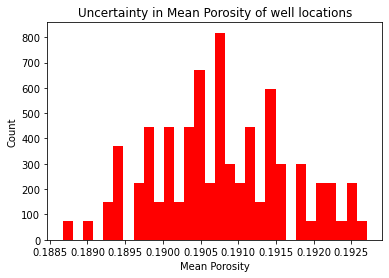

In [59]:
SGSIMreals = 0   #of SGSIM Models for a distribution
ndata = 50
sample_array = sim_sk.flatten()

goodwells = np.array([])                            #arrays of filterd samples from our SGSIM model using srategy
badwells = np.array([])
seeds = 0                       
for i in range(0,50):                                   
    index = int(np.random.randint(0,len(sample_array))) #pull from entire 10,000 data points of SGSIM model

while SGSIMreals < 5:           #number of isotropic SGSIM models for global distribution
    SGSIMreals += 1
    
    nx = 100; ny = 100; xsiz = 100.0; ysiz = 100.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
    ndmin = 0; ndmax = 10; radius = 400; skmean = 0
    vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45.0,hmaj1=1000,hmin1=1000)
    tmin = -999; tmax = 999

#SGSIM model
    seeds += 1
    sim_sk = geostats.sgsim(df_iso,'X','Y','porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
                twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
                nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seeds,
                ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
                mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

    
    sample_array = sim_sk.flatten()
    sampy = sample_array[50]
    print('sampy: ', str(sampy))
#-----------------------------------------------------------------------Setup Annular Region    
    nx = 100; ny = 100; xsiz = 100.0; ysiz = 100.0
    xmin = 0.0; xmax = 10000.0; ymin = 0.0; ymax = 10000.0

    x = np.linspace(xmin,xmax,nx)
    y = np.linspace(ymax,ymin,ny)
    X,Y = np.meshgrid(x,y)
    px = X.flatten()
    py = Y.flatten()

    
    index = np.random.randint(0,len(sample_array))     #want to start with a random location from SGSIM model
                              
    well_por = sample_array[index]                    #initial well location

#-----------------------------------------------------------------------Store Good Wells
    print('Applying Strategy for SGSIM model #'+ str(SGSIMreals))
    for i in range(0,wellcount):                              #want to drill 50 wells

        #define R1, R2 from major and minor axes, (here well assume R2 is a fraction of R1 for demonstration
        #since they are equal when Isotropic)
        Hmaj = 1000
        Hmin = Hmaj/3
        R1 = np.array([])
        for i in range(len(px)):
            R1 = np.append(R1,np.sqrt((px[i]-well_x)**2 + (py[i]-well_y)**2))

        annulus = np.where((R1 <= Hmaj)&(R1 > Hmin))[0]        #regions of good and bad wells
        outsideR1 = np.where(R1 > Hmaj)[0]

        r1 = np.where(((R1 > Hmaj-50))&(R1<(Hmaj+50)))[0]      #Radii for plotting
        r2 = np.where(((R1 > Hmin-50))&(R1<(Hmin+50)))[0]

        annulusx = np.array([])                                #good well arrays
        annulusy = np.array([])
        annuluspor = np.array([])

        out_annulusx = np.array([])                            #bad well arrays
        out_annulusy = np.array([])
        out_annuluspor = np.array([])                              

        for i in annulus:                                     #gathers x,y locations & porosities inside and outside annulus
            annulusx = np.append(annulusx,px[i])
            annulusy = np.append(annulusy,py[i])
            annuluspor = np.append(annuluspor,sample_array[i])
        for i in outsideR1:
            out_annulusx = np.append(out_annulusx,px[i])
            out_annulusy = np.append(out_annulusy,py[i])
            out_annuluspor = np.append(out_annuluspor,sample_array[i])
            
        if well_por >= threshold_por:                      #if a good well, sample stored for bootstrap, look inside annulus
            goodwells = np.append(goodwells,well_por)

            index = np.random.randint(0,len(annuluspor))
            well_x = annulusx[index]
            well_y = annulusy[index]
            well_por = annuluspor[index]
        
        elif well_por < threshold_por:                 #if a bad well, sample not stored for bootstrap , look outside annulus
            badwells = np.append(badwells,well_por)

            index = np.random.randint(0,len(out_annuluspor))
            well_x = out_annulusx[index]
            well_y = out_annulusy[index]
            well_por = out_annuluspor[index]

    print('Number of good wells so far: '+str(len(goodwells)))
    print(goodwells)
        
# by now we have our global distribution of 'good' wells drilled strategically accross multiple SGSIM models  

#-------------------------------------------------------------Bootstrap
mean_por = np.array([])
n = 0
while n < 100:                                     #n realizations (number of times we drill 50 wells)
    n+=1
    samples = np.array([])
    for i in range(0,len(goodwells)):
        index = np.random.randint(0,len(goodwells))
        samples = np.append(samples,goodwells[index])  #builds 1 full realization of 50 wells
    mean = np.mean(samples)
    mean_por = np.append(mean_por,mean)
    

#Visualize uncertainty distribution in single SGSIM model:

bins = 30
ax3 = plt.subplot(111)
n, bins,patches = plt.hist(mean_por,bins,facecolor = 'r',density=True)
plt.xlabel('Mean Porosity' )
plt.ylabel('Count')
plt.title('Uncertainty in Mean Porosity of well locations')

#plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.1, hspace=0.1)


## Comparing Standard Journelian Bootstrap to Journelian Bootstrap with Imposed Strategy

Both approaches created multiple unique SGSIM realizations to sample from and generated distributions for mean porosity, however to compare these 2 distributions accros 2 methods of sampling, we made sure to keep the unique SGSIM models the same accross both methods for an 'apples to apple' comparison, ensuring that the sample space is shared and any differences in the distributions are due to the different sampling methods.

## To Do
- overylay standard Journellian histogram with strategy journelian histogram
- use a cirlce as the 'annular' region for isotraopic examples.

# Anisotropy
In the case our data is Anisotropic, we wont have an isotropic variogram and we will need determine the major and minor azimuths for our SGSIM model. 
For this we can calculate the variogram in all directions and visaully determine our major and minor azimuths.  
Lets first build a dataframe needed to use our working data.

In [17]:
df = pd.read_csv('sample_data_MV_biased-3.csv')
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,293.260870,499.565217,520.644022,0.597826,0.127026,85.617362,4791.736646
std,169.058258,289.770794,277.412187,0.491004,0.030642,228.362654,974.560569
min,0.000000,0.000000,9.000000,0.000000,0.041122,0.094627,1981.177309
25%,150.500000,240.000000,269.000000,0.000000,0.103412,2.297348,4110.728374
50%,296.000000,500.000000,539.000000,1.000000,0.125842,10.377292,4713.325533
75%,439.500000,762.500000,769.000000,1.000000,0.148623,50.581288,5464.043562
max,586.000000,990.000000,999.000000,1.000000,0.210258,1991.097723,7561.250336


To fully appreciate the models we will build, lets reduce the number of true data points

In [18]:
df = df.sample(100)
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,297.150000,512.200000,513.270000,0.57000,0.127490,70.439191,4868.672649
std,162.926666,281.373184,286.029484,0.49757,0.027001,194.474376,985.983155
min,36.000000,0.000000,9.000000,0.00000,0.065537,0.260590,1981.177309
25%,158.500000,247.500000,269.000000,0.00000,0.107692,3.422460,4265.221658
50%,277.500000,510.000000,499.500000,1.00000,0.123966,12.201203,4791.517561
75%,447.500000,732.500000,789.000000,1.00000,0.148994,52.291463,5555.921384
max,571.000000,990.000000,979.000000,1.00000,0.204587,1665.384124,7561.250336


Lets visualize our spatial data

C:\Users\admin1\anaconda3\lib\site-packages\geostatspy\GSLIB.py:323: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(


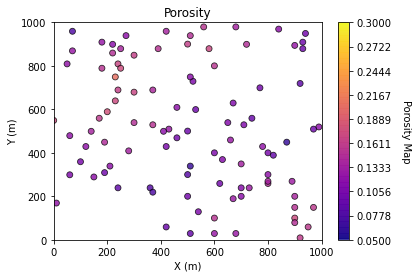

In [19]:
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,.05,.3,'Porosity','X (m)','Y (m)','Porosity Map',plt.cm.plasma)

- From this map, we can get a sense of the minimum lag distance we want to use for our variogram. 50m seems reasonable given the proximity of data. 
- Now lets calculate the variogram of our truth model. We are going to determine the correct major and minor variogram azimuths by measuring the ranges of multiple variogram calculations.


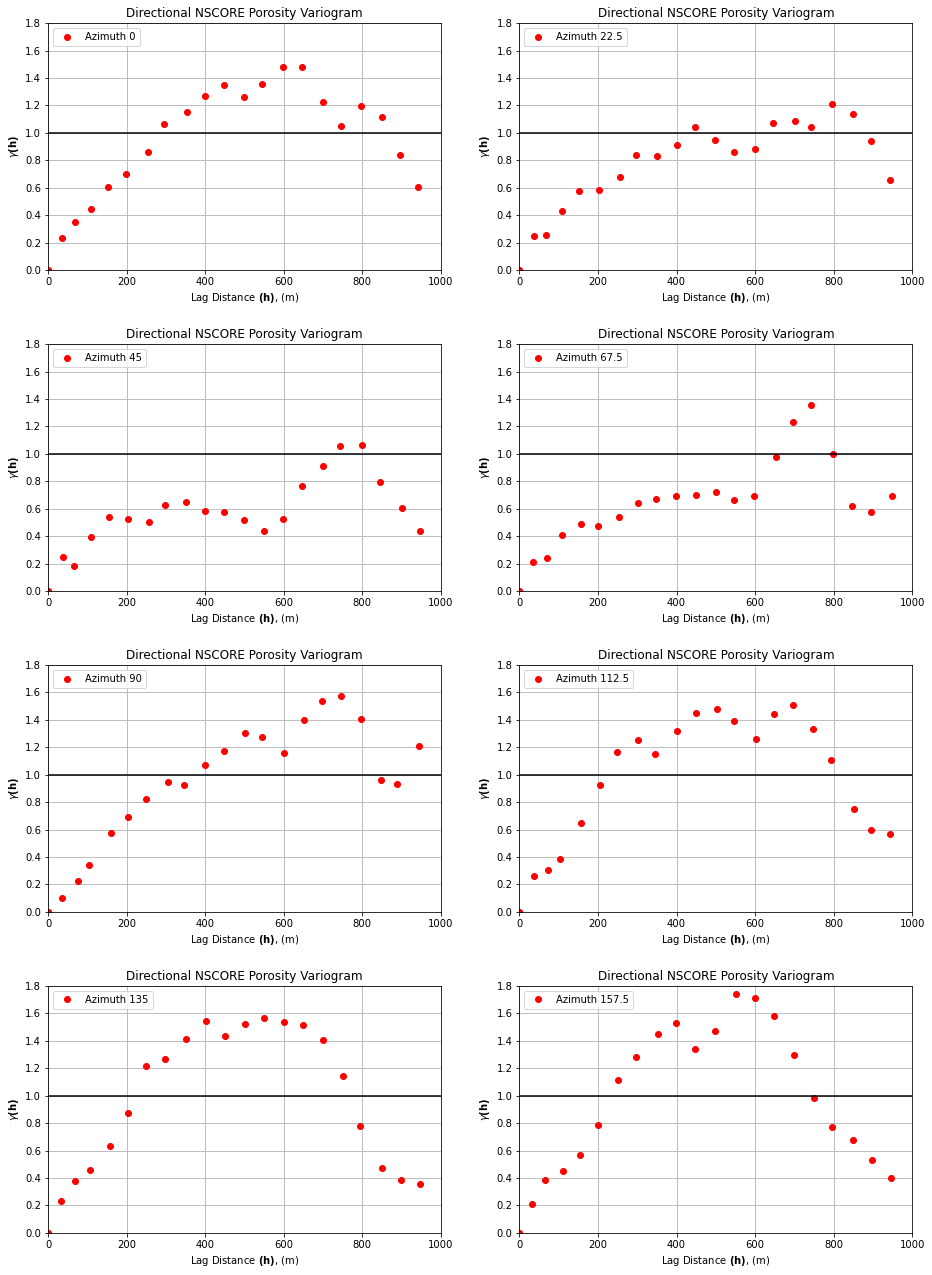

In [20]:
tmin = -9999.; tmax = 9999.                             # no trimming of our data 
lag_dist = 50.0; lag_tol = 50.0; nlag = 20;     # maximum lag is 1000m, log_tol > 1/2 lag distance (smoothing)
bandh = 9999.9; atol = 25                             # give bandwidth no effect: directional variograms
isill = 1                                               # standardize sill(equal to variance = 1 in normal trans)
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to consider

#Store results in these arrays
lag = np.zeros((len(azi_mat),nlag+2))
variogram = np.zeros((len(azi_mat),nlag+2))
z = np.zeros((len(azi_mat),nlag+2))

for azi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[azi,:], variogram[azi,:], z[azi,:] = geostats.gamv(df,"X","Y","Porosity",tmin,tmax,
                                                                lag_dist,lag_tol,nlag,azi_mat[azi],
                                                                atol,bandh,isill)
#visualize each variogram 
    plt.subplot(4,2,azi+1)
    plt.plot(lag[azi,:],variogram[azi,:],'o',color = 'r',label = 'Azimuth ' +str(azi_mat[azi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Porosity Variogram')
    plt.xlim([0,1000])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

By exploring a range of directions, we have built a spatial continuity elipse of our data. We see that our major axis is 45 degrees (Range = 900m) and our minor axis is 135 degrees (Range = 250m). We will use these azimuths for our SGSIM model, so that the model is consistent with our data going foward.



### Dealing With Anisotropy:
- We determined that R1, the outer limit of the annular region used to define a close new well, would be the major axis range of the variogram used in our SGSIM models. After calculating the variogram for our raw data, I observed geometric anisotropy in the spatial data and determined the major and minor azimuths. For the drilling strategy, defining an annular region surrounding a sample to randomly drill another well seems naive if we have a gerneral idea of where high porosity zones lie(45 degree azimuth), and where worse porosity is (135 degreee azimuth).  
- The idea of drilling close to or far from the previous drill depending on how good the sample was makes sense. However, I think I should implement more directionality in the strategy that will make the selection of a new drill less random Maybe within the annular region, if you had a good well and want to drill another close well, drill within the annulus, but make sure to drill along the 45 degree azimuth and avoid the 135 degree azimuth. And of course always avoid drilling within R2 (minor axis range of our variogram model).

- here's and image that explains my thinking.

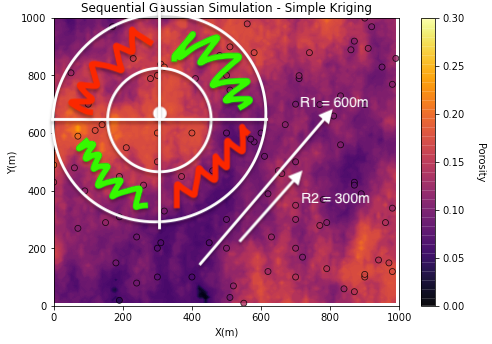

In [21]:
Image("anisotropy.PNG")